In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
def cargar_datos():
    dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
    return dataset['train'], dataset['test'], info

def preprocesar(imagen_mascara):
    imagen = imagen_mascara['image']
    mascara = imagen_mascara['segmentation_mask']

    imagen = tf.image.resize(imagen, (128, 128))
    imagen = imagen / 255.0
    mascara = tf.image.resize(mascara, (128, 128))
    mascara = tf.cast(mascara, tf.int32)
    return imagen, mascara

def augmentacion(imagen, mascara):
    imagen = tf.image.random_flip_left_right(imagen)
    imagen = tf.image.random_brightness(imagen, max_delta=0.1)
    imagen = tf.image.random_contrast(imagen, lower=0.8, upper=1.2)
    return imagen, mascara

def verificar_mascaras(test_dataset):
    for data in test_dataset.take(1):
        mascara_real = data['segmentation_mask']
        print("Valores únicos en la máscara real:", np.unique(mascara_real.numpy()))

In [ ]:
def modelo_unet():
    entrada = layers.Input((128, 128, 3))

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(entrada)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    u1 = layers.UpSampling2D((2, 2))(b1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    salida = layers.Conv2D(4, (1, 1), activation='softmax')(c4)

    modelo = models.Model(inputs=entrada, outputs=salida)
    modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return modelo


In [ ]:
def entrenar_modelo(train_dataset, test_dataset):
    train_dataset = train_dataset.map(preprocesar).map(augmentacion).batch(16).shuffle(100)
    test_dataset = test_dataset.map(preprocesar).batch(16)

    modelo = modelo_unet()
    modelo.fit(train_dataset, validation_data=test_dataset, epochs=5)
    return modelo

def evaluar_modelo(modelo_entrenado, test_dataset):
    test_dataset = test_dataset.map(preprocesar).batch(16)
    loss, accuracy = modelo_entrenado.evaluate(test_dataset)
    print(f'Pérdida: {loss}, Precisión: {accuracy}')

In [ ]:
def visualizar_prediccion(modelo_entrenado, test_dataset):
    test_dataset = test_dataset.map(preprocesar).batch(1)
    for imagen, mascara_real in test_dataset.take(1):
        prediccion = modelo_entrenado.predict(tf.expand_dims(imagen[0], 0))

        prediccion_clase = np.argmax(prediccion[0], axis=-1)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(imagen[0])
        plt.title('Imagen Original')

        plt.subplot(1, 3, 2)
        plt.imshow(mascara_real[0].numpy().squeeze(), cmap='gray')
        plt.title('Máscara Real')

        plt.subplot(1, 3, 3)
        plt.imshow(prediccion_clase, cmap='gray')
        plt.title('Máscara Predicha')

        plt.show()

Valores únicos en la máscara real: [1 2 3]
Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 45s 138ms/step - accuracy: 0.5779 - loss: 0.9168 - val_accuracy: 0.6232 - val_loss: 0.7871
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.6407 - loss: 0.7866 - val_accuracy: 0.6365 - val_loss: 0.7669
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.6716 - loss: 0.7552 - val_accuracy: 0.7286 - val_loss: 0.6632
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.6806 - loss: 0.7445 - val_accuracy: 0.7362 - val_loss: 0.6455
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.6898 - loss: 0.7332 - val_accuracy: 0.7398 - val_loss: 0.6366
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7399 - loss: 0.6372
Pérdida: 0.6366251111030579, Precisión: 0.7398263216018677
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


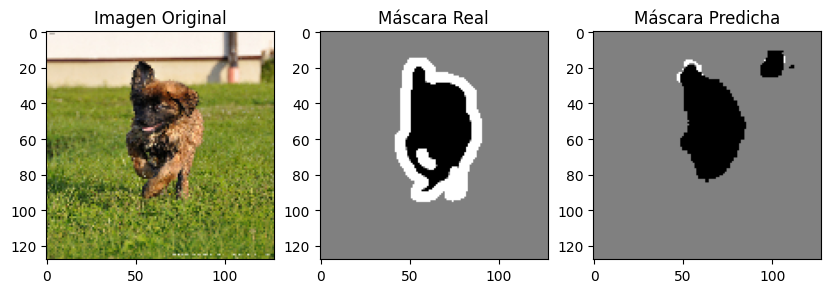

In [ ]:
train_dataset, test_dataset, info = cargar_datos()

verificar_mascaras(test_dataset)

modelo_entrenado = entrenar_modelo(train_dataset, test_dataset)

evaluar_modelo(modelo_entrenado, test_dataset)

visualizar_prediccion(modelo_entrenado, test_dataset)
